In [13]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import discretize
from pymatsolver import Pardiso as Solver
from SimPEG import maps, data, utils, optimization, regularization, inverse_problem, directives, inversion, data_misfit
# from SimPEG import maps, utils, data, optimization, maps, objective_function, regularization, inverse_problem, directives, inversion, data_misfit
from SimPEG.electromagnetics import natural_source as nsem
from discretize.utils import mkvc, ndgrid, active_from_xyz

from SimPEG.utils import plot2Ddata, surface2ind_topo
from pymatsolver import Pardiso as Solver


Forward modeling synthetic ZTEM data. Note that this notebook is decimated to be able to run on a typical laptop. The full version of the notebook is available in the repository. The notebook simulates data on one line, with a sparser mesh than typical, and only two frequencies.



## Problem set up
Define reciever locations


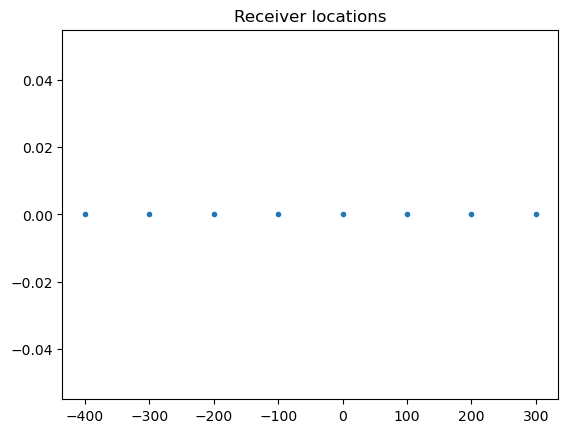

In [2]:
receiver_locations_x = np.arange(-400,400,100)
receiver_locations_y = np.ones_like(receiver_locations_x) * 0
receiver_locations_z = np.ones_like(receiver_locations_x) * 50

receiver_locations = np.c_[mkvc(receiver_locations_x), mkvc(receiver_locations_y), mkvc(receiver_locations_z)]

plt.plot(receiver_locations[:, 0], receiver_locations[:, 1], '.')
plt.title('Receiver locations')
plt.show()

## Mesh Design
For FDEM data, the mesh extent should be informed by the skin depth of the lowest and highest frequencies. The skin depth is given by:

\begin{equation}
\delta \approx 500\sqrt{\frac{1}{\sigma {f}}
\end{equation}

For ZTEM the lowest frequency is 30 Hz and highest is 720 Hz.
So assuming the background conductivity of 0.01 S/m,
skin depth for the highest frequency is 188 m and for the lowest frequency is 918 m.

The minimum cell size must be smaller than the minimum skin depth (typically 1/3 times), and the mesh size should extend to at least 2-3 times the maximum skin depths from the Tx.

For this example we will model a block in the center of the mesh with conductivity of 10 S/m.
For now, topography is assumed to be flat.

In [3]:
# domain OcTree mesh

dh = 50.0  # base cell width
dom_width_x = 4000.0  # domain width x
dom_width_y = 4000.0  # domain width y
dom_width_z = 4000.0  # domain width z

# Number of base mesh cells in each direction. Must be a power of 2
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]
mesh = discretize.TreeMesh([hx, hy, hz], x0="CCC")

#define core extent
core_points = ndgrid(
    np.r_[-600, 600], np.r_[-600, 600], np.r_[-800,0]
)

#Refine mesh around core region
mesh.refine_bounding_box(core_points, -1, padding_cells_by_level=[2, 4, 6], finalize=False)

#refine around receivers
mesh.refine_points(receiver_locations, padding_cells_by_level=[2, 4, 6], finalize=False)

mesh.finalize()
mesh

OcTreeMesh: 10.69% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  4   :      2656            ---------------------------   --------------------
  5   :      9542         x:    -1600.0   ,   1600.0          50.0   ,   200.0   
  6   :      15824        y:    -1600.0   ,   1600.0          50.0   ,   200.0   
-----------------------   z:    -1600.0   ,   1600.0          50.0   ,   200.0   
Total :      28022

# Define model

We create a L-shaped block around the center of the mesh with conductivity of 10 S/m. The background conductivity is 0.01 S/m.


In [4]:
# Define conductivity model on the mesh
sig_back = 1e-2
sig_block = 10
sig_air = 1e-8

model = sig_air * np.ones(mesh.nC)
model[mesh.cell_centers[:, 2] < 0] = sig_back
halfspace = model.copy()

ind_block1 = (
    (mesh.cell_centers[:, 0] > 0) & (mesh.cell_centers[:, 0] < 200) &
    (mesh.cell_centers[:, 1] > -300) & (mesh.cell_centers[:, 1] < 300) &
    (mesh.cell_centers[:, 2] > -400) & (mesh.cell_centers[:, 2] < -100)
)
ind_block2 = (
    (mesh.cell_centers[:, 0] > -300) & (mesh.cell_centers[:, 0] < 0) &
    (mesh.cell_centers[:, 1] > -100) & (mesh.cell_centers[:, 1] < 300) &
    (mesh.cell_centers[:, 2] > -400) & (mesh.cell_centers[:, 2] < -100)
)
model[ind_block1] = sig_block
model[ind_block2] = sig_block


# Mapping
Set the mapping between the model and forward simulation


In [5]:
#First we need to create a boolean array to tell the simulation which cells are active
#Air cells are excluded
active_inds = model > sig_air
actMap = maps.InjectActiveCells(mesh=mesh, indActive=active_inds, valInactive=np.log(sig_air))
# Conductivity changes logarithmically so we set it as an exponential map
mapping = maps.ExpMap(mesh) * actMap
active_model = model[active_inds]

Text(0, 0.5, 'y (m)')

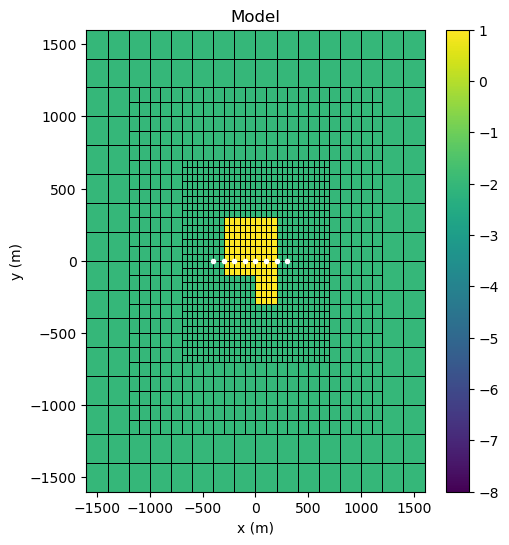

In [6]:
# Plot the model
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121)
out = mesh.plot_slice(np.log10(model), normal='Z', ax=ax1,ind=int(nbcz/2)-4, grid=True, pcolor_opts={"vmin":np.log10(sig_air), "vmax":np.log10(sig_block)},
        grid_opts={"color":"k", "lw":0.5},)
cb = plt.colorbar(out[0], orientation="vertical")
plt.plot(receiver_locations[:, 0], receiver_locations[:, 1], 'w.')
ax1.set_title('Model')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')



# Define survey

In [7]:
# Choose ZTEM frequencies to simulate (currently includes 6 standard ZTEM frequencies)
frequencies = np.r_[30, 720] # Less freqs for testing on laptop

# Make a receiver list
rx_list = []
for rx_orientation in ['zx', 'zy']:

    # specify that we are using tipper data
    rx_real = nsem.receivers.Point3DTipper(receiver_locations, rx_orientation, "real")
    rx_imag = nsem.receivers.Point3DTipper(receiver_locations, rx_orientation, "imag")

    # append to the receiver list
    rx_list.append(rx_real)
    rx_list.append(rx_imag)

# Source list
source_list = [
    nsem.sources.PlanewaveXYPrimary(rx_list, frequency=freq) for freq in frequencies
]

# Survey object
survey = nsem.Survey(source_list)

# Define the forward simulation

In [8]:
#Simulate data. Note that sigmaPrimary needs to be a flattened mesh object.
sim = nsem.Simulation3DPrimarySecondary(
    mesh, survey=survey, solver=Solver, sigmaMap=mapping, sigmaPrimary=halfspace
)

# Predict fields and data for a synthetic model
fields= sim.fields(model[active_inds])
dobs = sim.dpred(model[active_inds], f=fields)

In [9]:
data_obj = data.Data(survey, dobs=dobs)

In [10]:
dobs = np.savetxt("ztem_syn_fwd_demo.obs", dobs)

# Plot results

Text(0.5, 0, 'x (m)')

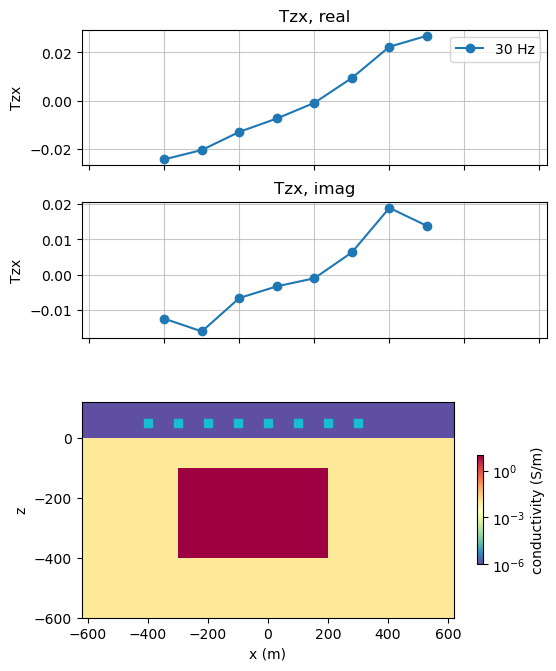

In [11]:
fig, ax = plt.subplots(3, 1, height_ratios=[1, 1, 2], figsize=(6, 8))

xlim = 620*np.r_[-1, 1]
ylim= np.r_[-600, 120]
src_ind = 4


for j, src in enumerate(source_list[::2]):
    for i, rx in enumerate(rx_list[:2]):
        ax[i].plot(receiver_locations_x, data_obj[src, rx], "-o", color=f"C{j}", label=f"{src.frequency:1.0f} Hz")
        ax[i].set_title(f"T{rx.orientation}, {rx.component}")
        ax[i].set_ylabel(f"T{rx.orientation}")

for a in ax[:2]:
    a.grid("both", alpha=0.7)
    a.set_xticklabels("")
    a.set_xlim(xlim)
ax[0].legend()

out = mesh.plot_slice(model, normal="y", ax=ax[2], pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=10), "cmap":"Spectral_r"})
cb = plt.colorbar(out[0], shrink=0.4)
cb.set_label("conductivity (S/m)")

ax[2].set_xlim(xlim)
ax[2].set_ylim(ylim)
ax[2].set_aspect(1)
ax[2].set_title("")
ax[2].plot(receiver_locations_x, np.ones_like(receiver_locations_x)*receiver_locations_z, "C9s")

ax[2].set_xlabel("x (m)")

In [19]:
#Export data
#data_obj.write(".data/ZTEM_data.obs")
# Assign uncertainties
data_obj.relative_error = 0.05  # 5% std
data_obj.noise_floor = 0.01
# sim.survey.std = np.abs(survey.dobs) * std
data_obj.noise_floor[-source_list[-1].nD:] = 0.005

# Inversion

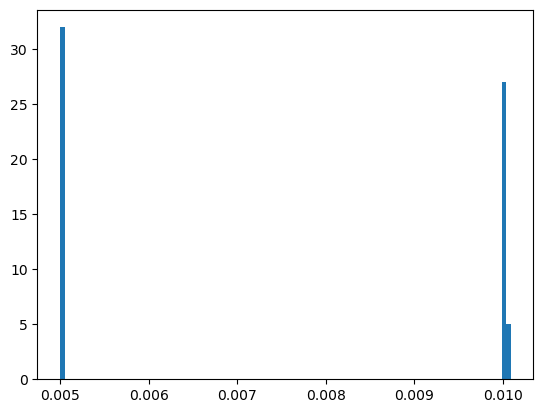

In [20]:
## Inversion
plt.hist(data_obj.standard_deviation, 100)
plt.show()


In [21]:

# Set the conductivity values
sig_half = 0.01
sig_air = 1e-8
# Make the background model
sigma_0 = np.ones(mesh.nC) * sig_air
sigma_0[active_inds] = sig_half
m_0 = np.log(sigma_0[active_inds])


In [ ]:
data_obj.standard_deviation

In [22]:
## Setup the inversion proceedure
# Define a counter
# Data misfit
dmis = data_misfit.L2DataMisfit(data=data_obj, simulation=sim)
# Regularization
regmap = maps.IdentityMap(nP=int(active_inds.sum()))
# reg = regularization.Sparse(mesh, indActive=active, mapping=regmap)

reg = regularization.WeightedLeastSquares(mesh, active_cells=active_inds, mapping=regmap, reference_model=m_0)
reg.alpha_s = 2.5e-5
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 0.25

# Optimization
C = utils.Counter()
opt = optimization.ProjectedGNCG(maxIter=8, upper=np.inf, lower=-np.inf, tolCG=1E-2, maxIterCG=20, )
opt.counter = C
opt.remember('xc')

# reg.mrefInSmooth = True
# Inversion problem
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=0.1)
invProb.counter = C
# Beta schedule
beta_cool = directives.BetaSchedule(coolingFactor=5, coolingRate=3)
# Initial estimate of beta
# beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# Target misfit stop
targmis = directives.TargetMisfit()
# targmis.target = survey.nD
saveIter = directives.SaveModelEveryIteration()
# Create an inversion object
directive_list = [beta_cool, targmis, saveIter]
inv = inversion.BaseInversion(invProb, directiveList=directive_list)

In [23]:

start = time.time()
# Run the inversion
mopt = inv.run(m_0)
print('Inversion took {0} seconds'.format(time.time() - start))
## Model Comparison


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DPrimarySecondary problem***
                        
SimPEG.SaveModelEveryIteration will save your models as: '.\###-InversionModel-2024-04-02-21-44.npy'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-01  1.91e+01  0.00e+00  1.91e+01    5.00e+00      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.0134e+00
1 : |xc-x_last| = 1.8847e+00 <= tolX*(1+|x0|) = 6.7550e+01
0 : |proj(x-g)-x|    = 4.9970e+00 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 4.9970e+00 <= 1e3*eps       = 1.0000e-02
0 : maxIter

In [30]:
data_misfit.Data

In [34]:
min(mesh.h[0])

50.0